## **Installation** 

- Install Docker and Conda.
- sudo usermod -aG docker "$USER" (on Linux)
- conda create -n scanflow python=3.6
- source activate scanflow
- git clone https://github.com/gusseppe/scanflow
- cd scanflow
- pip install -r requirements.txt

**In the future**

> Install Docker and Conda.

> pip install scanflow

## **Run scanflow server** 

It starts the **Scanflow UI** (dashboard) and **Scanflow API** (REST):

- python cli.py server

Then go to:

- http://localhost:8050

Note: By default server_port = 8050.

Use python cli.py --help for more information.

## **Steps**

- **Training**: Define the training executor using Pytorch and the MNIST data.
- **Inference**: Define an inference executor (batch) and a Predictor (online) to make predictions using a trained model.
    - Aditionally, we can define the **Agents**: Supervisor, Checker, Improver and Planner agent (more explanation about it below).
- **Detector training**: Define a detector training executor that will be trained on x_train. Built-in Scanflow executor (from submitted paper).
- **Detector Inference**: Define a detector inference executor for both anomaly detection and anomaly picker. It will be used by the Checker agent. Built-in Scanflow executor (from submitted paper).(https://colab.research.google.com/drive/1t0EgpPk5_mEMNb_AvN7yJ_Tz88bqgS9A). 
- **Retraining**: Define a retraining executor to retrain the model using x_train + x_chosen. It will be used by the Improver agent.
- **Labeling**: Define a labeling executor to label the x_chosen artifact (Future work). 
- **Custom app**: Call the inference executor from a web application.

# **Definition and Deployment** 📑

Here we start the definition of each step, it consists of setting the images, requirements, python scripts and parameters. This definition is set just once and the behaviour of each step can be changed by its parameters. In a production system, this notebook should be run once in order to start the network, tracker, executors and agents as containers. Then, these containers can be executed or reached on demand by using Scanflow API (e.g. call the Predictor or execute the inference batch).

## Model (training)

Let's get some MNIST data to train a CNN-based model.

In [1]:
import utils
x_train_sample, y_train_sample = utils.sample_train_mnist()
x_train_sample.shape

(1000, 28, 28)

We load only 1k instances (from the original 60k) to make the training faster hence the accuracy will be lower as well.

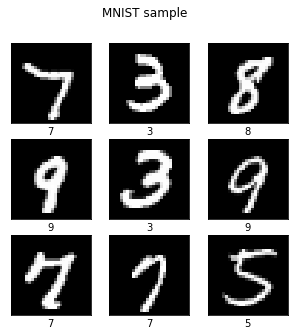

In [2]:
utils.show_numbers(x_train_sample, y_train_sample, title=f"MNIST sample")

Here we start the training executor definition. We need the following things:

**Input**
- Python script: `training.py`
- Parameters for the script: `model_name`, `x_train_path`, `y_train_path`, etc.
- requirements: `req_training.txt`, the required libraries to build the training image.

**Output**
- The input dataset for both training and testing (x_train, x_test, ...) will be saved in Tracker Repository (MLflow) to have a data version control.
- Model (mnist_cnn) and version (1,2,3 and on) will be saved and registered in the Tracker Repository. It will save the artifacts (serialized model) and register the model in the Model Registry.

Eventually, the data scientist will select a model version (from the Model Registry) and tag it as a "Production" Model. So that, this model will be use in the Inference stage.

In [13]:
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(1,'../..')
from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Predictor
from scanflow.special import Supervisor, Checker, Improver, Planner 
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# We can define a list of executors. 
# In this case, we only have one executor.
executors = [Executor(name='training', 
                      file='training.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'epochs':6,
                                  'x_train_path': './mnist_sample/train_images.npy', 
                                  'y_train_path': './mnist_sample/train_labels.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      requirements='req_training.txt')           
            ]

# A workflow contains a list of executors and also special nodes. 
# In this case, we have only one special node: Tracker MLflow.
workflow1 = Workflow(name='training-mnist', 
                     executors=executors,
                     tracker=Tracker()) # No agents involved
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

10-May-21 10:36:51 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['training-mnist']
)

All the experiments will be saved at MLflow UI: http://localhost:8002 (Tracker repository). It contains also the Model registry (where all the model versions are registered).

Once we have defined the training executor we can then build the corresponding images and start the workflow.

In [14]:
deployer = Deploy(setup)

deployer.build_workflows(True) # verbose=True
deployer.start_workflows(True) # verbose=True

10-May-21 10:36:53 -  WARNING - [+] Network: [network_scanflow] is already running.
10-May-21 10:36:53 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-repository/docker-compose.yml] was created successfully.
10-May-21 10:36:53 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-repository/main.py] was created successfully.
10-May-21 10:36:53 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-verbose/docker-compose.yml] was created successfully.
10-May-21 10:36:53 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-verbose/main.py] was created successfully.
10-May-21 10:36:53 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-swarm/docker-compose.yml] was created successfully.
10-May-21 10:36:53 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/st

Now we have a Docker container of name: {workflow-name}-{executor-name} running on the computer.

Then, we run the workflow to execute the script (in our case, training.py) inside the new created container. It performs the model training and then save a model version in the Model Registry (http://localhost:8002/#/models).


In [3]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 09:58:01 -  INFO - [++] Running workflow: [training-mnist].
10-May-21 09:58:01 -  INFO - [+] Running image: [training-mnist:training].
10-May-21 09:58:07 -  INFO - [+] Running (training.py). 
10-May-21 09:58:07 -  INFO - [+] Output:  /opt/conda/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text
/opt/conda/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `matplotlib` which is not installed yet, install it with `pip install matplotlib`.
  f' install it with `pip install {pypi_name}`.' + extra_text
/opt/conda/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  f' install it with `pip install {pypi_name}`.' + extra_text
Global seed

In [3]:
# Of course you can stop the workflows, 
# it will stop and prune all the created containers.
# deployer.stop_workflows()

07-May-21 11:06:31 -  INFO - [+] Environment: [training-mnist-training] was stopped successfully.
07-May-21 11:06:31 -  INFO - [+] Tracker: [tracker-mlflow] is not running in local.
07-May-21 11:06:31 -  INFO - [+] Stopped containers were pruned.
07-May-21 11:06:31 -  INFO - [+] Network: [network_training-mnist] is not running in local.


## Model (inference)



### Batch and Online

Similar to the training part, we define the inference executor (**batch**). We need the following:

- Python script: `inference-batch.py`
- Parameters for the script: `x_inference_path`, `model_name` and `model_version`.
- requirements: `req_inference_batch.txt`, the required libraries to build the inference image.

Apart from the inference executor we also define a Predictor and the special agents:

- **Predictor**: this node creates both the UI and API for the **online** inference. It requires the `predictor.py` that is similar to the `inference-batch.py`. Located at `stuff/predictor/predictor.py`
- **Supervisor**: the one in charge of linking the multi agent system to the outside. For instance, it can get the x_inference and feed it to the Checker agent. Located at `stuff/supervisor/agent/supervisor_agent.py`
- **Checker**: this agent calls the detector to get the anomalies and the chosen instances to be considered for the retraining. The Checker's output is the feedback. `stuff/supervisor/agent/checker_agent.py`
- **Improver**: it decides what to do with the feedback. For instance, if n_anomalies > threshold, then perform a retraining with x_train + x_chosen. `stuff/supervisor/agent/improver_agent.py`
- **Planner**: this agent receives the order from the Improver to make some changes in the original workflow. For instance, change the current "Production" model by the new created model from the Improver. `stuff/supervisor/agent/planner_agent.py`

In [15]:
# This executor can receive any mnist model name and version (from Model Registry).
# This inference is of type "batch", meaning that the inference 
# is done by a python script (predict) and not deployed as an API (REST).

executors = [Executor(name='inference', 
                      file='inference-batch.py',
                      parameters={'model_name':'mnist_cnn',
                                  'model_version':'1',
#                                   'model_stage':'Production',
                                  },
                      image='training-mnist-training')           
            ]


# Almost with the same inference-batch.py code you can get an online predictor.
# This predictor has both an UI (localhost:8010) and API (localhost:8011)

predictor = Predictor(file ='predictor.py', # located at stuff/predictor
                      image='training-mnist-training', #reuse the training image
                      port = 8010,
                      function = 'main') # function inside predictor.py that has the I/O.

workflow1 = Workflow(name='inference-mnist', 
                     executors=executors,
                     tracker=Tracker(), #mlflow
                     predictor=predictor,
                     
                     supervisor=Supervisor(),
                     checker=Checker(),
                     improver=Improver(),
                     planner=Planner())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

10-May-21 10:37:10 -  INFO - [Predictor] Port 8010 is in use by Predictor.
10-May-21 10:37:10 -  INFO - [Tracker] Port 8002 is in use by Tracker.
10-May-21 10:37:10 -  INFO - [Supervisor] Port 8003 is in use by Supervisor.
10-May-21 10:37:10 -  INFO - [Checker] Port 8004 is in use by Checker.
10-May-21 10:37:10 -  INFO - [Improver] Port 8005 is in use by Improver.
10-May-21 10:37:10 -  INFO - [Planner] Port 8006 is in use by Planner.



Setup = (
    Workflows: ['inference-mnist']
)

In [16]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()
# deployer.pipeline() # Build, Start and Run all together

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


In [3]:
# deployer.run_workflows(True)

In [5]:
# deployer.stop_workflows()

## Detector (training)

This executor trains the drift detector using the **x_train**. It learns the original distribution patterns to then detect if the **x_inference** follows a similar one.

In [17]:
# This detector-batch comprises an anomaly detector and a picker
executors = [Executor(name='detector-training', 
                      file='detector-training.py',
                      parameters={'name': 'detector_mnist',
                                  'x_train_path': './mnist_sample/train_images.npy',
                                  },
                      requirements='req_detector.txt')           
            ]


workflow1 = Workflow(name='detector-training-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup


Setup = (
    Workflows: ['detector-training-mnist']
)

In [18]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 10:37:23 -  INFO - [++] Starting workflow: [detector-training-mnist].
10-May-21 10:37:23 -  INFO - [+] Starting image: [detector-training-mnist:detector-training].
10-May-21 10:37:23 -  WARNING - [+] Environment: [detector-training-mnist-detector-training] is already running.
10-May-21 10:37:23 -  INFO - [+] Starting image: [tracker-mlflow.
10-May-21 10:37:23 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
10-May-21 10:37:23 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 10:37:23 -  INFO - [+] [containers_alive.json] was loaded successfully.
10-May-21 10:37:23 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 10:37:23 -  INFO - [+] Workflow: [detector-training-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


In [8]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 10:24:58 -  INFO - [++] Running workflow: [detector-training-mnist].
10-May-21 10:24:58 -  INFO - [+] Running image: [detector-training-mnist:detector-training].
10-May-21 10:25:05 -  INFO - [+] Running (detector-training.py). 
10-May-21 10:25:05 -  INFO - [+] Output:  2021-05-10 08:24:59.664977: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-05-10 08:24:59.665020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-05-10 08:25:01.764991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-10 08:25:01.765798: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.

In [30]:
# deployer.stop_workflows()

## Detector (inference)

This executor contains the detector (for inference) and the picker. This detector will be used by the Checker agent.

In [19]:
# This detector-batch comprises an anomaly detector and a picker
# It requires the inference run_id from where to get the artifacts.
# Apart from the run_id it requires the artifact paths. 
# Both run_id and artifact paths can be changed dynamically.

executors = [Executor(name='detector-batch', 
                      file='detector-batch.py',
                      parameters={'run_id': 'inference_run_id', 
                                  'x_inference_artifact': 'x_inference.npy',
                                  'y_inference_artifact': 'y_inference.npy'
                                 },
                      requirements='req_detector.txt')           
            ]

workflow1 = Workflow(name='detector-inference-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

10-May-21 10:37:30 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['detector-inference-mnist']
)

In [10]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 10:25:31 -  INFO - [++] Starting workflow: [detector-inference-mnist].
10-May-21 10:25:31 -  INFO - [+] Starting image: [detector-inference-mnist:detector-batch].
10-May-21 10:25:31 -  WARNING - [+] Environment: [detector-inference-mnist-detector-batch] is already running.
10-May-21 10:25:31 -  INFO - [+] Starting image: [tracker-mlflow.
10-May-21 10:25:31 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
10-May-21 10:25:31 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 10:25:31 -  INFO - [+] [containers_alive.json] was loaded successfully.
10-May-21 10:25:31 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 10:25:32 -  INFO - [+] Workflow: [detector-inference-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


In [33]:
# deployer.stop_workflows()

06-May-21 20:31:30 -  INFO - [+] Environment: [detector-inference-mnist-detector-batch] was stopped successfully.
06-May-21 20:31:30 -  INFO - [+] Tracker: [tracker-mlflow] is not running in local.
06-May-21 20:31:30 -  INFO - [+] Stopped containers were pruned.
06-May-21 20:31:30 -  INFO - [+] Network: [network_detector-inference-mnist] is not running in local.


In [58]:
# deployer.run_workflows(verbose=True)

## Retraining

This executor will be used by the Improver agent to retrain the model. So that, the new training dataset will be as follows:

**Without human intervention**

> x_new_train = x_train + x_chosen.

> y_new_train = y_train + y_predicted.

**With human intervention**

> x_new_train = x_train + x_chosen.

> y_new_train = y_train + y_human_labeled.

In [20]:
executors = [Executor(name='retraining', 
                      file='retraining.py',
                      parameters={'model_name': 'mnist_cnn_retrained',
                                  'run_id': 'inference_run_id',
                                  'x_new_train_artifact': 'x_inference.npy', 
                                  'y_new_train_artifact': 'y_inference.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      image='training-mnist-training') #reuse the training image         
            ]


workflow1 = Workflow(name='retraining-mnist', 
                     executors=executors,
                     tracker=Tracker())
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

10-May-21 10:37:39 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['retraining-mnist']
)

In [21]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)

  0%|          | 0/1 [00:00<?, ?it/s]10-May-21 10:37:41 -  INFO - [++] Starting workflow: [retraining-mnist].
10-May-21 10:37:41 -  INFO - [+] Starting image: [retraining-mnist:retraining].
10-May-21 10:37:41 -  WARNING - [+] Environment: [retraining-mnist-retraining] is already running.
10-May-21 10:37:41 -  INFO - [+] Starting image: [tracker-mlflow.
10-May-21 10:37:41 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
10-May-21 10:37:41 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 10:37:41 -  INFO - [+] [containers_alive.json] was loaded successfully.
10-May-21 10:37:41 -  INFO - [Tracker]  'Scanflow' experiment loaded.
10-May-21 10:37:41 -  INFO - [+] Workflow: [retraining-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


In [59]:
# deployer.run_workflows(verbose=True)

In [16]:
# deployer.stop_workflows()

## Labeling (Human agent)

It contains the Active learning step. Available soon

# **Productionizing** 🖥️

## Custom App

Scanflow provides a ready-to-use app when creating a `Predictor` node (http://localhost:8010/), of course, you can also create custom apps for any executor.

You can embed scanflow executors into your web apps. For this example we provide two apps using `gradio` to create custom UIs:

- `pip install gradio`
- `python app1.py mnist_cnn 1`
- `python app2.py mnist_cnn 1`

Where `mnist_cnn` is the model's name and `1` is its version. You can find them at http://localhost:8002/#/models

## Agent Explanation

It provides the explanation of each agent decision.

Please go to http://localhost:8050/agents

# Remove all the metadata

It will remove artifacts, metrics, params and also registered models.

In [1]:
import pandas as pd
import os
import sys
sys.path.insert(0,'../..')

from scanflow import track

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")
tracker = track.Tracker(app_dir)
# last_artifacts = tracker.list_artifacts(workflow_name='mnist')
# print(last_artifacts.keys())


In [9]:
# tracker.delete_tracked_data()